This code incorporates architectures from Experiment files 1-3 into a single file. 

In [ ]:
!pip install torch torchvision

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using device: cpu


In [ ]:
import os
from torchvision.datasets import ImageFolder
from google.colab import drive
drive.mount('/content/drive')
from torch.utils.data import DataLoader

data_dir = "/content/drive/MyDrive/Neuro140/FinalProject/Data/"

class CustomImageDataset(ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super(CustomImageDataset, self).__init__(root, transform=transform, target_transform=target_transform)

def create_dataloaders(train_root, val_root, test_root, batch_size):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = CustomImageDataset(train_root, transform=transform)
    val_dataset = CustomImageDataset(val_root, transform=transform)
    test_dataset = CustomImageDataset(test_root, transform = transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

train_root = data_dir + "train"
val_root = data_dir + "valid"
test_root = data_dir + "test"
train_loader, val_loader, test_loader = create_dataloaders(train_root, val_root, test_root, batch_size=10)


Mounted at /content/drive


In [ ]:
print(f"Number of classes in train dataset: {len(train_loader.dataset.class_to_idx)}")
print(f"Number of classes in validation dataset: {len(val_loader.dataset.class_to_idx)}")
print(f"Number of classes in test dataset: {len(test_loader.dataset.class_to_idx)}")
print(f"Class-to-index mapping in train dataset: {train_loader.dataset.class_to_idx}")
print(f"Class-to-index mapping in validation dataset: {val_loader.dataset.class_to_idx}")
print(f"Class-to-index mapping in test dataset: {test_loader.dataset.class_to_idx}")

Number of classes in train dataset: 2
Number of classes in validation dataset: 2
Number of classes in test dataset: 2
Class-to-index mapping in train dataset: {'Cars': 0, 'Dogs': 1}
Class-to-index mapping in validation dataset: {'Cars': 0, 'Dogs': 1}
Class-to-index mapping in test dataset: {'Cars': 0, 'Dogs': 1}


In [ ]:
class ToyCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ToyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = ToyCNN().to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [ ]:
import torch.nn.functional as F

def train(net, train_loader, num_classes, optimizer, device, criterion):
    net.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Print labels for debugging
        if i%100 == 0:
            print(f"Iteration {i}: Labels: {labels}")

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    return train_loss

def validate(net, val_loader, criterion, device):
    net.eval()
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Print labels for debugging
            if i%100 == 0:
                print(f"Iteration {i}: Labels: {labels}")

            outputs = net(inputs)
            #_, predicted = torch.max(outputs, 1)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()

    #accuracy = correct / total
    #return accuracy
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_loss = running_loss / len(val_loader)
    return val_loss

num_classes = 2
num_epochs = 2
for epoch in range(num_epochs):
    train_loss = train(net, train_loader, num_classes, optimizer, device, criterion)
    val_loss = validate(net, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Iteration 0: Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1])
Iteration 100: Labels: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])
Iteration 200: Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
Iteration 300: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
Iteration 400: Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 1])
Iteration 500: Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
Iteration 600: Labels: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
Iteration 700: Labels: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Iteration 0: Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Iteration 100: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Epoch 1, Train Loss: 0.3146, Validation Loss: 0.1377
Iteration 0: Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 1])
Iteration 100: Labels: tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1])
Iteration 200: Labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
Iteration 300: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Iteration 400: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
Iteration 500: Labels: 

In [ ]:
#Polysemanticity measure based on 'Engineering Monosemanticity in Toy Models' code
def measure_polysemanticity(layer):
    activations = []

    def hook(module, input, output):
        activations.append(output)

    hook_handle = layer.register_forward_hook(hook)

    # Pass a batch of images through the network
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = net(images)

    hook_handle.remove()

    # Calculate mean activations for each neuron
    mean_activations = [torch.mean(a, dim=(0, 2, 3)).cpu().numpy() for a in activations]
    mean_activations = np.stack(mean_activations).mean(axis=0)

    return mean_activations

conv1_polysemanticity = measure_polysemanticity(net.conv1)
conv2_polysemanticity = measure_polysemanticity(net.conv2)

print("Conv1 Polysemanticity:", conv1_polysemanticity)
print("Conv2 Polysemanticity:", conv2_polysemanticity)


Conv1 Polysemanticity: [-0.23869926 -0.96686816 -0.12721044 -0.08401273 -0.10691293 -0.9567182 ]
Conv2 Polysemanticity: [-1.086079   -1.1751949  -0.5869536  -0.8870102  -0.66193414 -0.89243674
 -1.2075353  -0.3008577  -0.7883178  -0.80624074 -1.7030694  -0.65105873
 -0.19822122 -0.74900436 -1.3225629  -0.9559894 ]


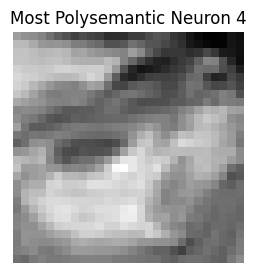

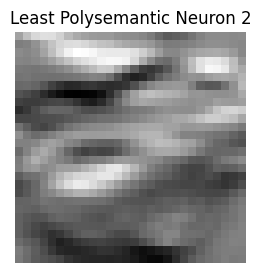

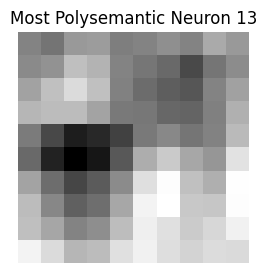

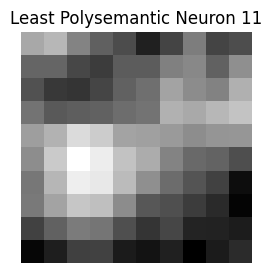

In [ ]:
#This code visualizes 
import matplotlib.pyplot as plt 

def visualize_polysemantic_neurons(layer, polysemanticity, num_neurons=1):
    most_polysemantic_indices = polysemanticity.argsort()[-num_neurons:]
    least_polysemantic_indices = polysemanticity.argsort()[:num_neurons]

    activations = []

    def hook(module, input, output):
        activations.append(output)

    hook_handle = layer.register_forward_hook(hook)

    # Pass a batch of images through the network
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        _ = net(images)

    hook_handle.remove()

    for idx, title in zip([most_polysemantic_indices, least_polysemantic_indices], ['Most', 'Least']):
        if num_neurons > 1:
            fig, axs = plt.subplots(1, num_neurons, figsize=(3 * num_neurons, 3))
            for i, neuron_idx in enumerate(idx):
                feature_map = activations[0][0, neuron_idx].cpu().numpy()
                axs[i].imshow(feature_map, cmap='gray')
                axs[i].axis('off')
                axs[i].set_title(f'{title} Polysemantic Neuron {neuron_idx + 1}')
        else:
            fig, ax = plt.subplots(figsize=(3, 3))
            neuron_idx = idx[0]
            feature_map = activations[0][0, neuron_idx].cpu().numpy()
            ax.imshow(feature_map, cmap='gray')
            ax.axis('off')
            ax.set_title(f'{title} Polysemantic Neuron {neuron_idx + 1}')
        plt.show()

# Visualize the most and least polysemantic neurons in conv1 and conv2
visualize_polysemantic_neurons(net.conv1, conv1_polysemanticity)
visualize_polysemantic_neurons(net.conv2, conv2_polysemanticity)


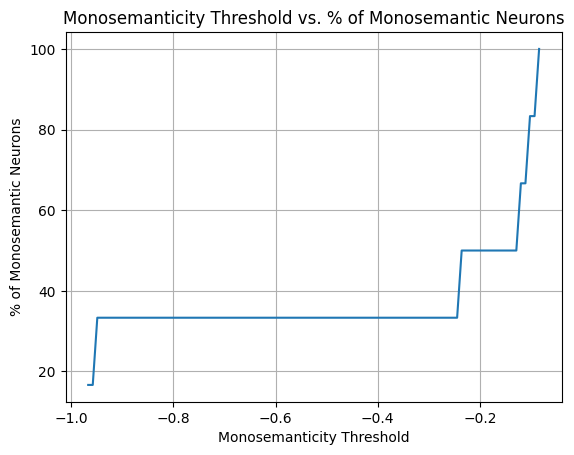

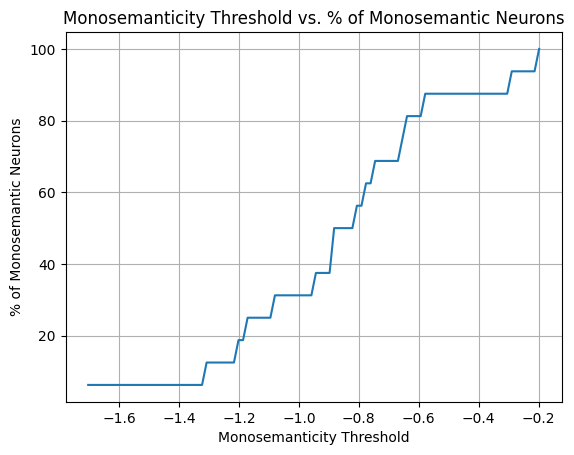

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_monosemanticity(polysemanticity, num_thresholds=100):
    thresholds = np.linspace(polysemanticity.min(), polysemanticity.max(), num_thresholds)
    percentages = []

    for threshold in thresholds:
        monosemantic_neurons = np.sum(polysemanticity <= threshold)
        percentage = (monosemantic_neurons / polysemanticity.size) * 100
        percentages.append(percentage)

    plt.plot(thresholds, percentages)
    plt.xlabel('Monosemanticity Threshold')
    plt.ylabel('% of Monosemantic Neurons')
    plt.title('Monosemanticity Threshold vs. % of Monosemantic Neurons')
    plt.grid()
    plt.show()

# Example usage with conv1_polysemanticity
plot_monosemanticity(conv1_polysemanticity)

plot_monosemanticity(conv2_polysemanticity)

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor, Normalize

def test_image(model, image_path, device):
    # Load the image
    img = Image.open(image_path)

    # Apply the same transformations as for the validation dataset
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img_tensor = transform(img)
    
    # Add an extra dimension for the batch
    img_tensor = img_tensor.unsqueeze(0)

    # Move the tensor to the device (CPU or GPU)
    img_tensor = img_tensor.to(device)
    
    # Pass the image through the model
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        print(output)
    # Get the predicted class
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()

    return predicted_class

# Assuming the toy model is named 'net'
net.eval()

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

# Test the image
image_path = "/content/drive/MyDrive/Neuro140/FinalProject/Data/test/Dogs/n02105251_8543_jpg.rf.195df8cf088e29dc394f86917972dd53.jpg"
predicted_class = test_image(net, image_path, device)

# Output the result
class_names = ["Cars", "Dogs"]
print(f"Predicted class: {class_names[predicted_class]}")

tensor([[-3.0360,  3.9572]])
Predicted class: Dogs


In [ ]:
#Run a test over all data. Return % correct
def test_nn(model, device, test_loader):
    net.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)
            if i%10 == 0:
                print(f"Iteration {i}: Labels: {labels}")
                print(str(labels.size(0)) + " = labels, inputs = " + str(inputs.size(0)))
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()


    return correct/total    

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)
print(test_nn(net, device, test_loader))


Iteration 0: Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
10 = labels, inputs = 10
Iteration 10: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
Iteration 20: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
Iteration 30: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
Iteration 40: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
Iteration 50: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
Iteration 60: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
Iteration 70: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
Iteration 80: Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
10 = labels, inputs = 10
0.9508379888268157


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Test with CIFAR10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_dir = "/content/drive/MyDrive/Neuro140/FinalProject/TestData/"

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

num_classes = 2

#train_dogs = ImageFolder(data_dir + "Dogs/Train", transform=train_transform)
train_data = ImageFolder(data_dir + "Train", transform=train_transform)
#train_data = torch.utils.data.ConcatDataset([train_dogs, train_cars])
trainloader = DataLoader(train_data, batch_size=100, shuffle=True, num_workers=2)

#val_dogs = ImageFolder(data_dir + "Dogs/Val", transform=val_transform)
val_data = ImageFolder(data_dir + "Valid", transform=val_transform)
#val_data = torch.utils.data.ConcatDataset([val_dogs, val_cars])
valloader = DataLoader(val_data, batch_size=100, shuffle=True, num_workers=2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
